
### Planetscope Analysis - Thresholding
***
Thresholding is a simple way of segmenting objects from a background.  
This script applies thresholding algorithms from scikit-image on vegetation indicies(NDVI, EVI, IPVI) over a study area in the Brazilian Amazon for segmenting forest/non-forest areas.



In [ ]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
%pip install -qr requirements.txt 

In [11]:
!git clonee https://github.com/planetlabs/notebooks
%cd notebooks

git: 'clonee' is not a git command. See 'git --help'.

The most similar command is
	clone
[Errno 2] No such file or directory: 'notebooks'
/home/jovyan/shared/Learning materials/subsections/4.*/code/Planetscope_preprocessing-main


In [4]:
pip install planet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 5.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install planet-client-python

ERROR: Could not find a version that satisfies the requirement planet-client-python (from versions: none)
ERROR: No matching distribution found for planet-client-python
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import requests
from planet import api
from planet.api import filters

# Set your API key
os.environ['PL_API_KEY'] = 'PLAK4cffca3f98d749f5af9814f5a62a5b7c'

client = api.ClientV1()

# Define the item type and asset type
item_type = "PSScene3Band"
asset_type = "analytic_sr"

# Define the image ID
image_id = "20190721_133242_1034_3B_AnalyticMS_Ref_clip_ndvi"

# Build a filter to find the specific image
geom_filter = filters.geom_filter({
    "type": "Point",
    "coordinates": [-122.4194, 37.7749]  # example coordinates, replace with the coordinates relevant to your image
})
date_range_filter = filters.date_range('acquired', gte='2019-07-21T00:00:00Z', lte='2019-07-21T23:59:59Z')

# Combine filters
combined_filter = filters.and_filter([geom_filter, date_range_filter])

# Search for the image
request = filters.build_search_request(combined_filter, item_types=[item_type])
result = client.quick_search(request)

# Iterate over search results and download the desired image
for item in result.items_iter(100):
    if item['id'] == image_id:
        # Activate the asset
        asset = item['assets'][asset_type]
        client.activate(asset)
        
        # Wait for the asset to be ready
        assets = client.get_assets(item).get()
        asset_status = assets[asset_type]["status"]
        while asset_status != 'active':
            time.sleep(10)
            assets = client.get_assets(item).get()
            asset_status = assets[asset_type]["status"]
        
        # Download the asset
        download_link = assets[asset_type]["location"]
        response = requests.get(download_link, stream=True)
        
        with open(f'{image_id}.tif', 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        
        print(f"Downloaded {image_id}.tif")
        break


ImportError: cannot import name 'api' from 'planet' (/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/planet/__init__.py)

In [1]:
import matplotlib.pyplot as plt
from skimage import io, color
from skimage import data
from skimage.filters import try_all_threshold
import rasterio
from rasterio.plot import show
%matplotlib inline

In [2]:
# Images for testing
ndvi_small = "Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_ndvi.tif"
evi_small = "Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_evi.tif"
ipvi_small = "Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_ipvi.tif"
savi_small = "Testing_data/True_data/20190726_133225_103a_3B_AnalyticMS_Ref_clip_savi.tif"

RasterioIOError: Testing_data/True_data/20190721_133242_1034_3B_AnalyticMS_Ref_clip_ndvi.tif: No such file or directory

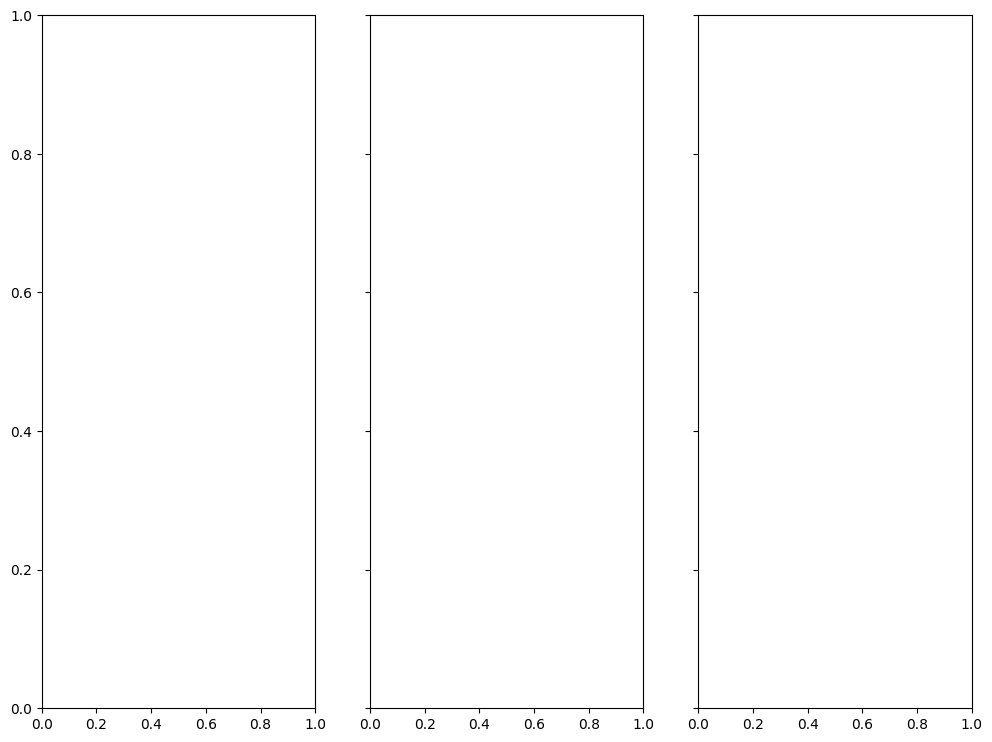

In [3]:
# Initialize subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 9), sharey=True)

# Plot Red, Green and Blue (rgb)
show(rasterio.open(ndvi_small), cmap='viridis', ax=ax1)
show(rasterio.open(evi_small), cmap='viridis', ax=ax2)
show(rasterio.open(ipvi_small), cmap='viridis', ax=ax3)
# Add titles
ax1.set_title("NDVI")
ax2.set_title("EVI")
ax3.set_title("IPVI")

NDVI and IPVI looks best for distinguishing forest from non-forest.   
EVI has a smoother histogram and works better for many of the threshold algorithms

In [83]:
with rasterio.open(ndvi_small) as src:
    ndvi_band = src.read(1)
print(ndvi_band)

[[       nan        nan        nan ... 0.67073573 0.68066667        nan]
 [       nan        nan        nan ... 0.65929956 0.6639839         nan]
 [0.69813554 0.69423253 0.69780045 ... 0.65676796 0.65153538        nan]
 ...
 [       nan 0.62048193 0.63133641 ...        nan        nan        nan]
 [       nan 0.63842418 0.63188871 ...        nan        nan        nan]
 [       nan 0.65249933 0.63714209 ...        nan        nan        nan]]


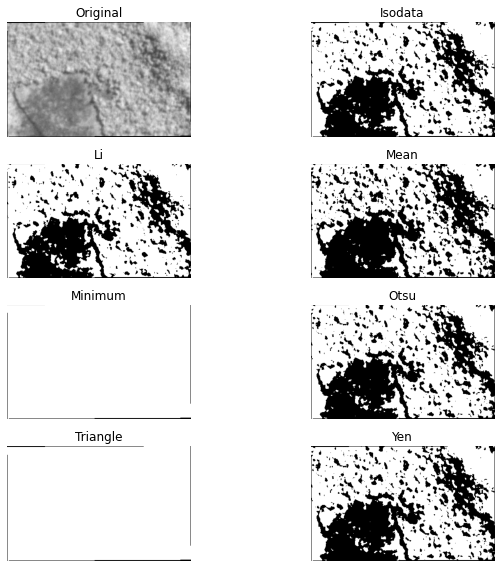

In [84]:
image = io.imread(evi_small, as_gray=True)

# Showing EVI, since the smoother histogram works better for these thresholding algorithms
fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()

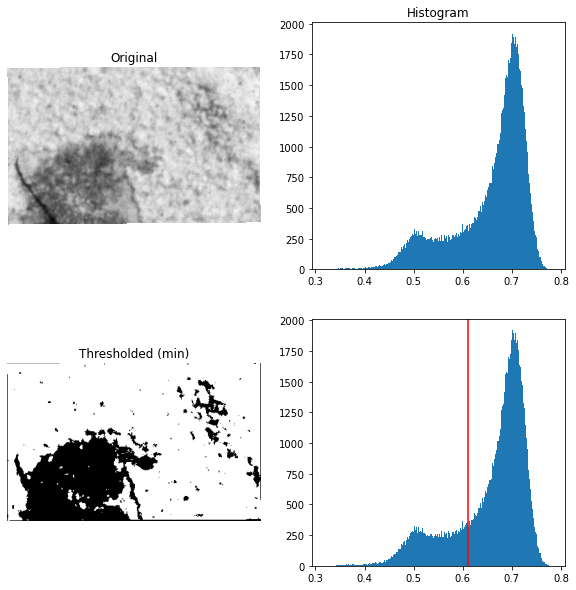

In [85]:
# Mean threshold did not work well on NDVI and IPVI because of strongly skewed distributions
# Therefore set mean manually
image = io.imread(ndvi_small, as_gray=True) # NDVI image is used further
from skimage.filters import threshold_mean

thresh = 0.6
binary = image > thresh

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

In [86]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

<class 'numpy.ndarray'>


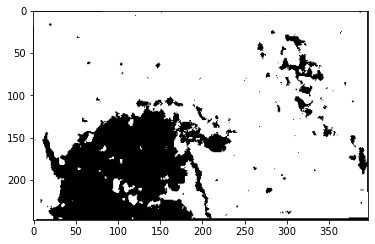

In [87]:
# Converting and smoothening result
img_ubyte = img_as_ubyte(binary)
print(type(binary))
plt.imshow(binary, cmap=plt.cm.gray)

Applying majority filter to smoothen results

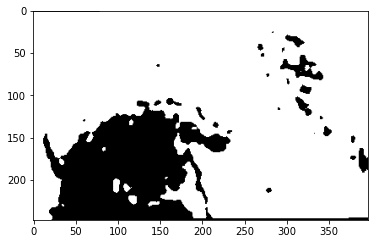

In [88]:
from skimage import data
from skimage.filters.rank import majority
from skimage.morphology import disk, ball
import numpy as np

#volume = np.random.randint(0, 255, size=(1,1,1), dtype=np.uint8)
maj_img = majority(img_ubyte, disk(3))
plt.imshow(maj_img, cmap=plt.cm.gray)

In [89]:
print(src.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 397, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(32722), 'transform': Affine(3.0, 0.0, 239181.0,
       0.0, -3.0, 9274158.0)}


In [92]:
# Export segmented mask
from rasterio import uint8
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.uint8,
    nodata=0.2,
    count = 1)

# Create the file
with rasterio.open(ndvi_small.replace('.tif', '_Mask.tif'), 'w', **kwargs) as dst:
                   dst.write_band(1, maj_img)